<a href="https://colab.research.google.com/github/VamsiPutheti12/ML-DL/blob/main/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define zip file path and target extraction folder
zip_path = '/content/drive/MyDrive/plant.zip'
extract_path = '/content/plantvillage'  # this will be inside Colab's /content/ folder

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/plantvillage


In [ ]:
# List top-level folders inside the dataset
import os

data_dir = '/content/plantvillage/PlantVillage'  # in most versions this is the folder name

classes = os.listdir(data_dir)
print(f'Total Classes: {len(classes)}')
print(classes[:10])  # show first 10 classes


Total Classes: 15
['Tomato_Leaf_Mold', 'Potato___healthy', 'Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Tomato_Bacterial_spot', 'Tomato_Late_blight']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data directory
data_dir = '/content/plantvillage/PlantVillage'

# Define ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Create training generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


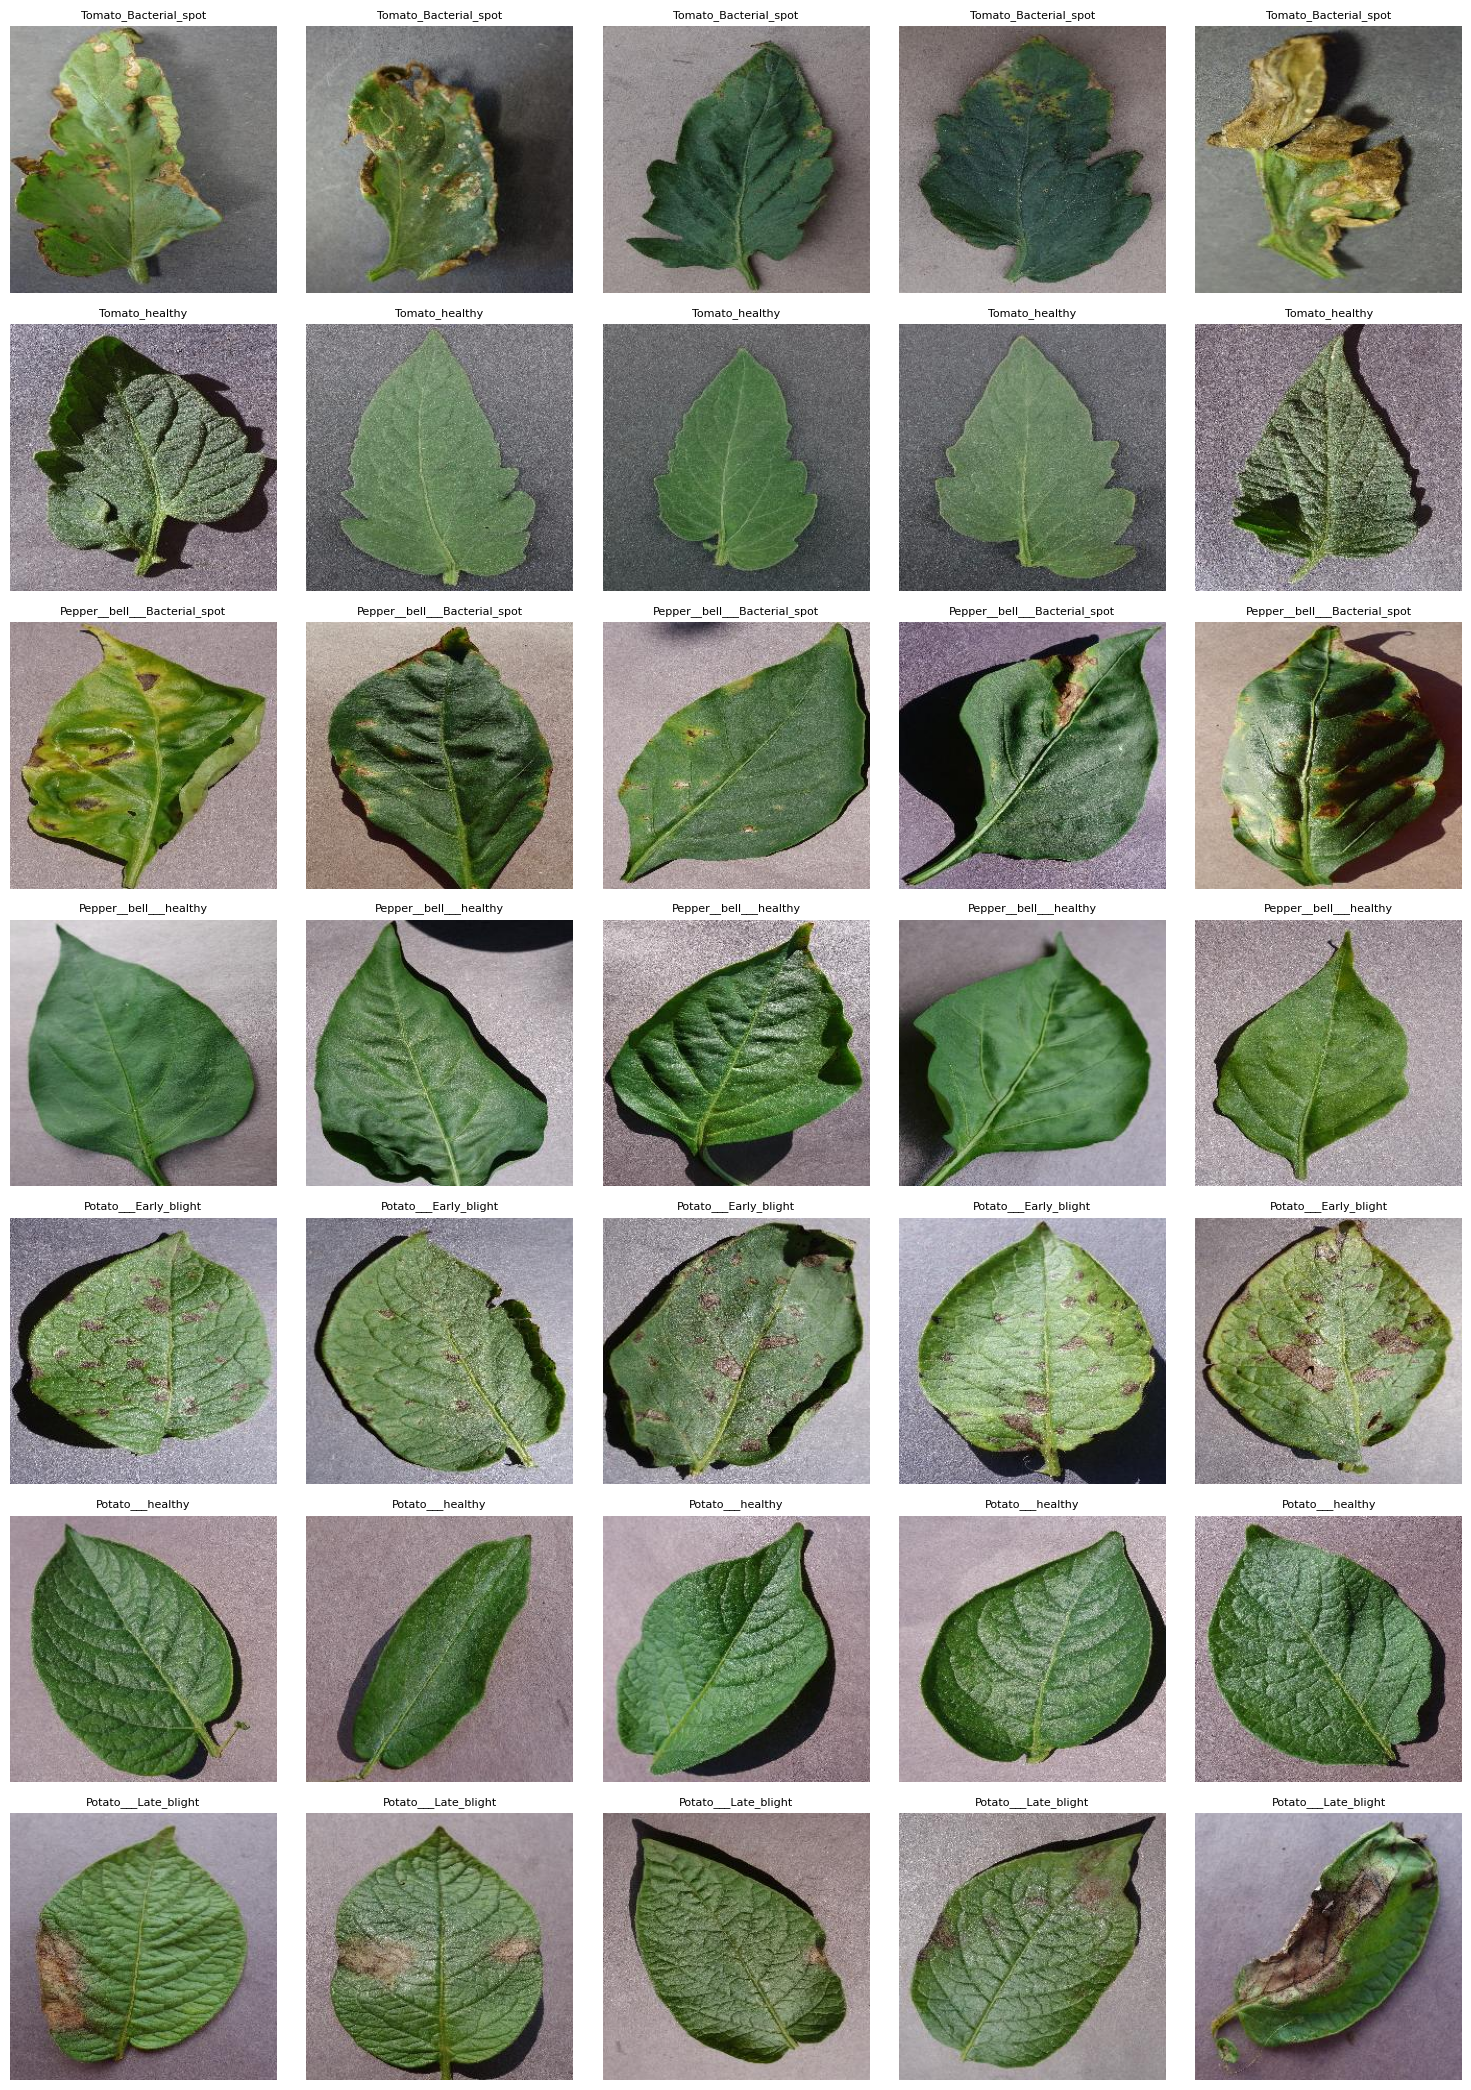

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Parameters
data_dir = '/content/plantvillage/PlantVillage'

# Classes to display (you can edit this list)
target_classes = ['Tomato_Bacterial_spot', 'Tomato_healthy',
                  'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
                  'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# How many images per class to display
images_per_class = 5

# Display loop
plt.figure(figsize=(15, len(target_classes) * 3))

img_index = 1
for target_class in target_classes:
    class_dir = os.path.join(data_dir, target_class)
    img_filenames = os.listdir(class_dir)
    # Randomly select images
    selected_imgs = random.sample(img_filenames, min(images_per_class, len(img_filenames)))

    for img_file in selected_imgs:
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)

        plt.subplot(len(target_classes), images_per_class, img_index)
        plt.imshow(img)
        plt.title(target_class, fontsize=8)
        plt.axis('off')

        img_index += 1

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model initially

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Optional: Save the best model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Optional: Stop training if no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Start with 10, you can increase if Colab GPU allows
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7494 - loss: 0.7571

517/517 ━━━━━━━━━━━━━━━━━━━━ 254s 492ms/step - accuracy: 0.7495 - loss: 0.7570 - val_accuracy: 0.8622 - val_loss: 0.4236
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 253s 489ms/step - accuracy: 0.7879 - loss: 0.6371 - val_accuracy: 0.8622 - val_loss: 0.4295
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8061 - loss: 0.5861

517/517 ━━━━━━━━━━━━━━━━━━━━ 252s 488ms/step - accuracy: 0.8061 - loss: 0.5861 - val_accuracy: 0.8753 - val_loss: 0.3707
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8205 - loss: 0.5381

517/517 ━━━━━━━━━━━━━━━━━━━━ 250s 483ms/step - accuracy: 0.8205 - loss: 0.5381 - val_accuracy: 0.8874 - val_loss: 0.3504
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 250s 484ms/step - accuracy: 0.8258 - loss: 0.5211 - val_accuracy: 0.8823 - val_loss: 0.3532
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8299 - loss: 0.4951

517/517 ━━━━━━━━━━━━━━━━━━━━ 253s 490ms/step - accuracy: 0.8299 - loss: 0.4952 - val_accuracy: 0.8877 - val_loss: 0.3369
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 256s 496ms/step - accuracy: 0.8366 - loss: 0.4929 - val_accuracy: 0.8874 - val_loss: 0.3463
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 253s 490ms/step - accuracy: 0.8425 - loss: 0.4711 - val_accuracy: 0.8785 - val_loss: 0.3433
Epoch 9/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 252s 487ms/step - accuracy: 0.8412 - loss: 0.4769 - val_accuracy: 0.8838 - val_loss: 0.3206
Epoch 10/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 286s 553ms/step - accuracy: 0.8472 - loss: 0.4555 - val_accuracy: 0.8874 - val_loss: 0.3169


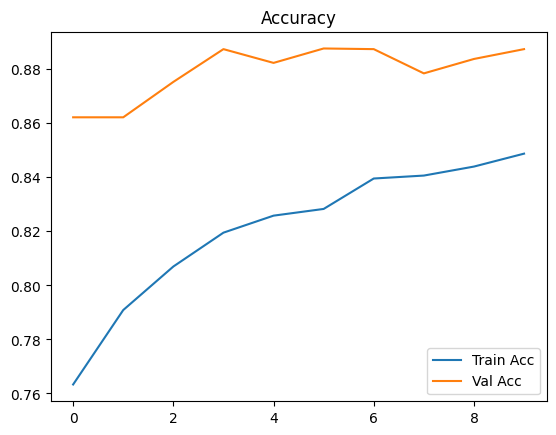

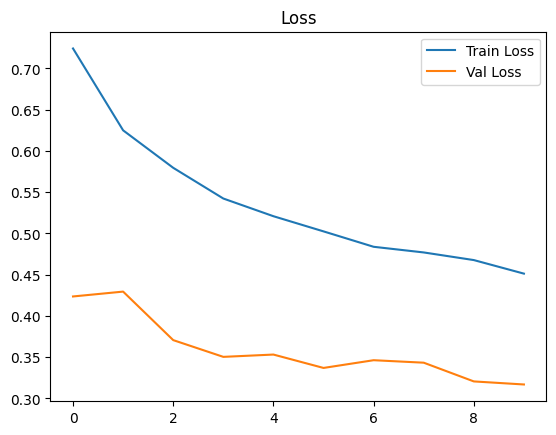

In [ ]:
import matplotlib.pyplot as plt
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


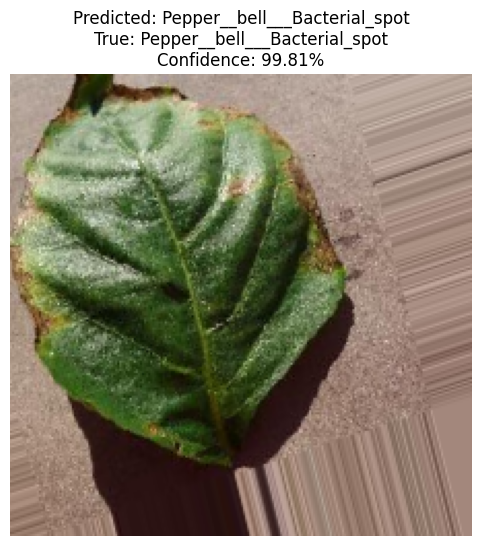

In [ ]:
# Prepare reverse lookup for class labels
class_indices = val_generator.class_indices
idx_to_class = dict((v, k) for k, v in class_indices.items())

# Function to predict and display a single image
def demo_single_prediction(val_generator, model, image_index=0):
    batch_images, batch_labels = next(val_generator)
    image = batch_images[image_index]
    true_label_idx = np.argmax(batch_labels[image_index])
    true_label = idx_to_class[true_label_idx]

    # Predict
    image_input = np.expand_dims(image, axis=0)
    pred_probs = model.predict(image_input)
    pred_idx = np.argmax(pred_probs)
    pred_label = idx_to_class[pred_idx]

    # Display Image + Prediction
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label}\nTrue: {true_label}\nConfidence: {pred_probs[0][pred_idx]*100:.2f}%", fontsize=12)
    plt.show()

# Run the demo
demo_single_prediction(val_generator, model, image_index=0)


129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 409ms/step


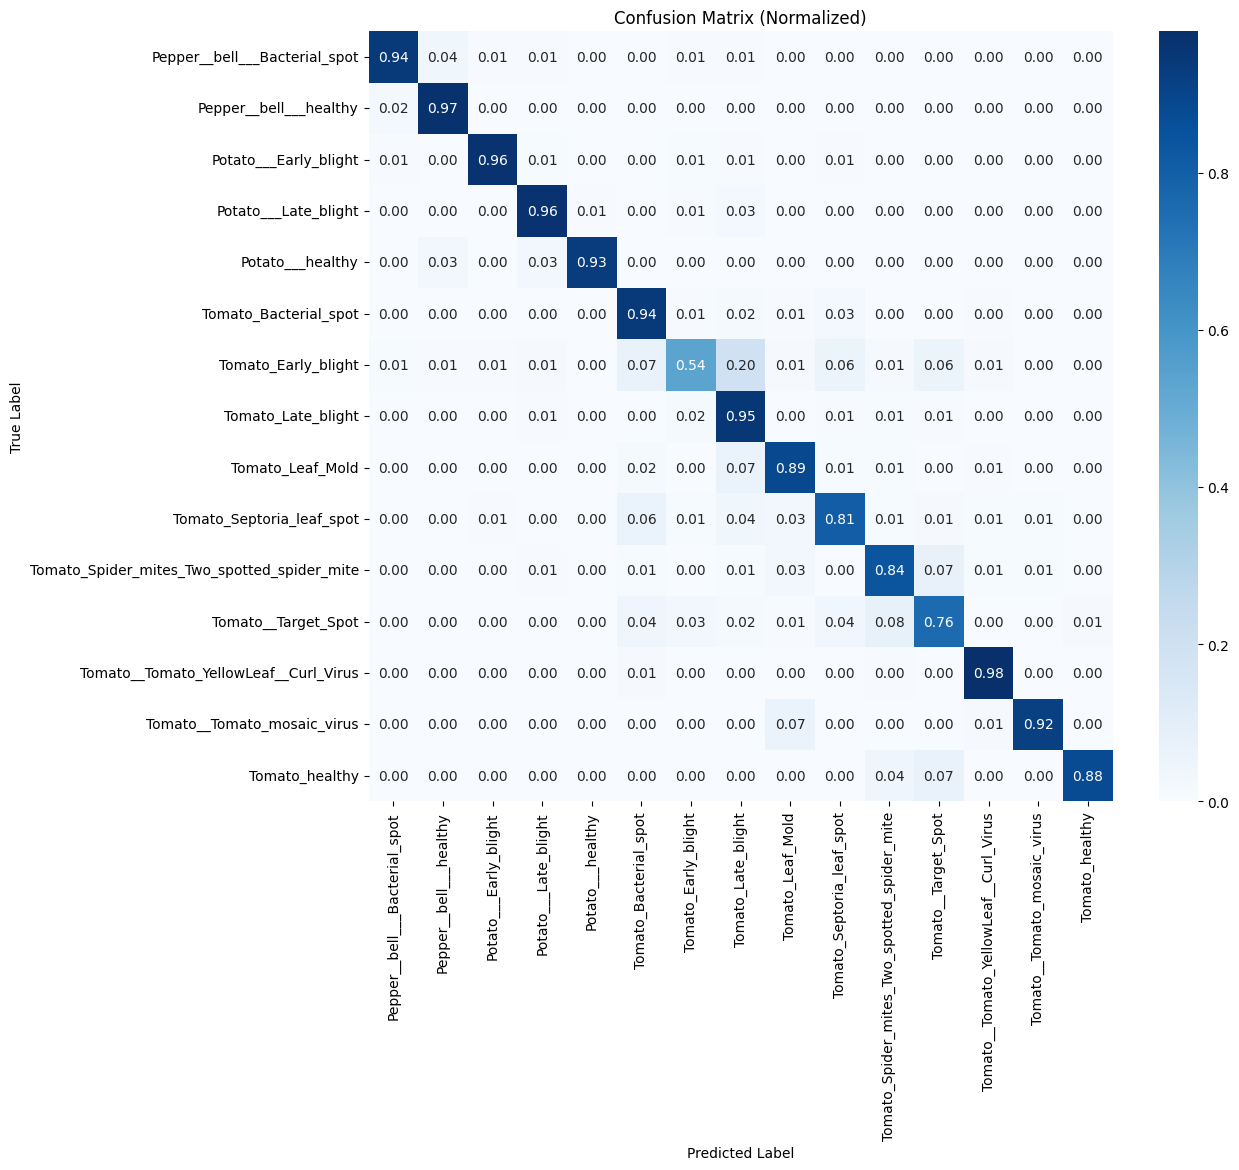

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.94      0.94       199
                     Pepper__bell___healthy       0.96      0.97      0.97       295
                      Potato___Early_blight       0.98      0.96      0.97       200
                       Potato___Late_blight       0.94      0.96      0.95       200
                           Potato___healthy       0.93      0.93      0.93        30
                      Tomato_Bacterial_spot       0.86      0.94      0.90       425
                        Tomato_Early_blight       0.78      0.54      0.64       200
                         Tomato_Late_blight       0.80      0.95      0.87       381
                           Tomato_Leaf_Mold       0.82      0.89      0.85       190
                  Tomato_Septoria_leaf_spot       0.88      0.81      0.84       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.85      0.84

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on full validation set
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=True, cmap='Blues',
            xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values(), fmt='.2f')
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=idx_to_class.values())
print(report)


In [ ]:
model.save('/content/drive/MyDrive/crop_disease_mobilenetv2_model.keras')


In [ ]:
from tensorflow.keras.models import load_model

# Load .keras format
model = load_model('/content/drive/MyDrive/crop_disease_mobilenetv2_model.keras')

# OR, if you saved as .h5
# model = load_model('/content/drive/MyDrive/crop_disease_mobilenetv2_model.h5')

# Summary to verify it's loaded
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,589,792 (9.88 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 165,905 (648.07 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


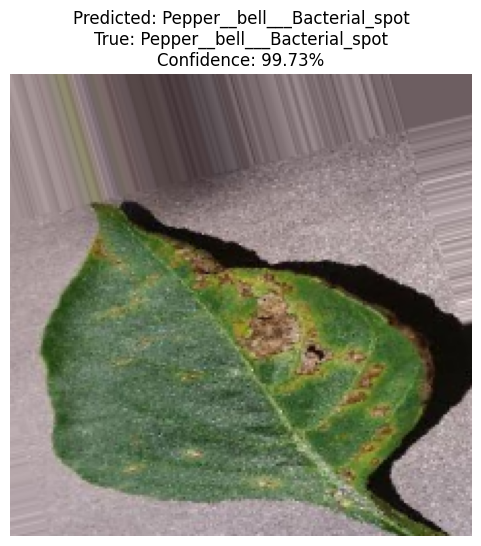

In [ ]:
# Example: run prediction again
val_generator.reset()
demo_single_prediction(val_generator, model, image_index=0)
